# TotalSegmentatorを用いたbody(体輪郭)ラベルの作成

In [422]:
import sys
import os
import warnings
from typing import Optional
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import nibabel as nib
from tqdm import tqdm
%matplotlib inline

# リポジトリtopに移動
while os.path.basename(os.getcwd()) != 'rsna-2023':
    os.chdir('../')
    if os.getcwd() == '/':
        raise Exception('Could not find project root directory.')
sys.path.append("./models")
sys.path.append("./models/totalsegmentator")
from models.totalsegmentator.python_api import totalsegmentator

In [2]:
df_train = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/train.csv')
df_train_image_level = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/image_level_labels.csv')
df_train_serirs_meta = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/train_series_meta.csv')

dataset_dir = "data/dataset003"

In [ ]:
# pid=38541のsid=63205でエラー、この症例はbodyの推論ができていない.

In [8]:
df_train_serirs_meta[df_train_serirs_meta["series_id"] == 63205]

,patient_id,series_id,aortic_hu,incomplete_organ
2350,38541,63205,135.0,0


In [7]:
os.listdir(base_dir)[102]

'63205.nii'

In [6]:
base_dir = "data/rsna-2023-abdominal-trauma-detection/segmentations/"
for sid in tqdm(os.listdir(base_dir)[103:]):
    sid = int(sid.replace(".nii", ""))
    pid = df_train_serirs_meta[df_train_serirs_meta["series_id"] == sid]["patient_id"].values[0]
    ct_images_dir = f"data/rsna-2023-abdominal-trauma-detection/train_images/{pid}/{sid}"
    output_dir = os.path.join(dataset_dir, "segmentations", str(pid), str(sid))
    os.makedirs(output_dir, exist_ok=True)
    ret = totalsegmentator(ct_images_dir, output_dir, task="body", verbose=False, quiet=True)

 19%|█▉        | 20/103 [15:58<1:02:15, 45.01s/it]

Shape of output image is very big. Setting nr_threads_saving=1 to save memory.


100%|██████████| 103/103 [1:25:27<00:00, 49.79s/it]


In [168]:
def load_series_from_dataset(dir_: str)-> np.ndarray:
    """seriesを読み込む."""
    path_list = os.listdir(dir_)
    path_list = [[int(path.replace(".npy","")), path] for path in path_list]
    path_list.sort()
    path_list = [path[1] for path in path_list]
    arr = []
    for path in path_list:
        arr.append(np.load(os.path.join(dir_, path)))
    return np.array(arr)

def match_orientation(img: np.ndarray) -> np.ndarray:
    """niftyの向きをdicomの向きに合わせる.
    Args:
        img (numpy.ndarray): 読み込んで、npに変換しただけのnifty画像.
    Reference:
        https://www.kaggle.com/code/parhammostame/construct-3d-arrays-from-dcm-nii-3-view-angles
    """
    img = np.transpose(img, [1, 0, 2])
    img = np.rot90(img, 1, (1,2))
    img = img[::-1,:,:]
    img = np.transpose(img, [1, 0, 2])
    return img

def load_mask_from_nifty(path: str)-> np.ndarray:
    """niftyファイルからマスクを読み込む."""
    mask = nib.load(path).get_fdata()
    mask = np.array(mask, dtype=np.uint8)
    mask = match_orientation(mask)
    return mask

def crop_region(img: np.ndarray, mask: np.ndarray, margin: int = 0) -> np.ndarray:
    """マスクされた領域を切り出す."""
    if margin > 0:
        mask = np.pad(mask, margin, mode="constant", constant_values=0)
    mask = np.where(mask > 0, 1, 0)
    x, y, z = np.where(mask > 0)
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    z_min, z_max = z.min(), z.max()
    if margin > 0:
        x_min = max(x_min - margin, 0)
        x_max = min(x_max + margin, mask.shape[0])
        y_min = max(y_min - margin, 0)
        y_max = min(y_max + margin, mask.shape[1])
        z_min = max(z_min - margin, 0)
        z_max = min(z_max + margin, mask.shape[2])
    return img[x_min:x_max, y_min:y_max, z_min:z_max], mask[x_min:x_max, y_min:y_max, z_min:z_max]

In [405]:

pid = 16494
sid = 6130
ct_dir = f"data/dataset001/train_images/{pid}/{sid}"
mask_path = f"data/dataset003/segmentations/{pid}/{sid}/body_trunc.nii.gz"

In [406]:
ct = load_series_from_dataset(ct_dir)
mask = load_mask_from_nifty(mask_path)

In [418]:
mask.shape

(176, 512, 512)

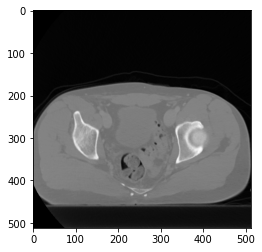

In [414]:
idx = 130
plt.imshow(ct[idx], cmap="gray")
plt.show()

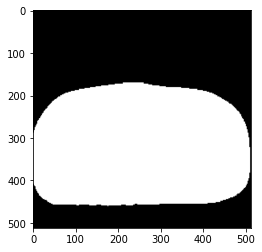

In [417]:
plt.imshow(mask[idx], cmap="gray")
plt.show()

In [357]:
# ct_cropped, mask_cropped = crop_region(ct, mask, margin=0)

In [415]:
# 上肢が写り込んでいるスライスまではbody_truncを使用し
# それより下のスライスはbodyを使用することで、下肢は体幹部として見なす.
# 下肢をbodyで抽出できれば良いので、上肢が写り込んでいなければスライスレベルはある程度適当で良い.
# Noneは上肢を挙上しており、全てbodyで抽出して良い症例.
arm_lower_slice = {
    # study_id: slice(index)
    62556: None,
    13307: 200,
    19468: 200,
    5176: 200,
    8236: 200,
    4622: None,
    28079: None,
    778: 200,
    24149: 100,
    21057: 300,
    51033: 300,
    16066: 300,
    30522: 300,
    31085: 100,
    30843: 100,
    12039: 100,
    13041: 100,
    39013: 670,
    19360: 50,
    6172: 50,
    24774: 50,
    12900: 100,
    8413: 200,
    24442: 100,
    6631: 100,
    39205: 100,
    55965: 100,
    42680: 100,
    6305: 50,
    6130: 100
}

In [423]:
def get_body_mask(body_trunc: np.ndarray, body: np.ndarray, idx: Optional[int]=None) -> np.ndarray:
    """bodyのマスクを取得する."""
    if idx is None:
        return body
    assert body.shape == body_trunc.shape
    concat_arr = np.concatenate([body_trunc[:idx], body[idx:]], axis=0)
    assert concat_arr.shape == body.shape
    return concat_arr

In [425]:
# dataset004として、以上のデータセットを作成.
ds004 = "data/dataset004/segmentations"

for sid, idx in tqdm(arm_lower_slice.items()):
    pid = df_train_serirs_meta[df_train_serirs_meta["series_id"] == sid]["patient_id"].values[0]
    body_trunc_mask_path = f"data/dataset003/segmentations/{pid}/{sid}/body_trunc.nii.gz"
    body_mask_path = f"data/dataset003/segmentations/{pid}/{sid}/body.nii.gz"
    body_trunc_mask = load_mask_from_nifty(body_trunc_mask_path)
    body_mask = load_mask_from_nifty(body_mask_path)
    concat_mask = get_body_mask(body_trunc_mask, body_mask, idx)
    output_dir = os.path.join("data/dataset004", "segmentations", str(sid))
    os.makedirs(output_dir, exist_ok=True)
    ct_dir = f"data/dataset001/train_images/{pid}/{sid}"
    ct_list = os.listdir(ct_dir)
    ct_list = [int(path.replace(".npy","")) for path in ct_list]
    ct_list.sort()
    assert len(ct_list) == concat_mask.shape[0]
    for i, ct in enumerate(ct_list):
        np.savez_compressed(os.path.join(output_dir, f"{ct}.npz"), concat_mask[i])

100%|██████████| 30/30 [00:26<00:00,  1.11it/s]


In [87]:
# dataset001のsegmentations(liver, kidney, spleen, bowel)と
# dataset003(body)を結合したdataset004を作成.
except_series = [63205,]
ds001 = "data/dataset001/segmentations"
ds003 = "data/dataset003/segmentations"
ds004 = "data/dataset004/segmentations"
base_dir = "data/rsna-2023-abdominal-trauma-detection/segmentations/"
for sid in tqdm(os.listdir(base_dir)):
    sid = int(sid.replace(".nii", ""))
    if sid in except_series:
        continue
    pid = df_train_serirs_meta[df_train_serirs_meta["series_id"] == sid]["patient_id"].values[0]
    seg_body_path = os.path.join(ds003, str(pid), str(sid), "body.nii.gz")
    seg_body = load_mask_from_nifty(seg_body_path)
    seg_organs_dir = os.path.join(ds001, str(sid))
    ct_dir = f"data/dataset001/train_images/{pid}/{sid}"
    ct_list = os.listdir(ct_dir)
    ct_list = [int(path.replace(".npy","")) for path in ct_list]
    ct_list.sort()
    assert seg_body.shape[0] == len(ct_list)
    # 出力ディレクトリの作成
    output_dir = os.path.join(ds004, str(sid))
    os.makedirs(output_dir, exist_ok=True)
    for idx, slice_num in enumerate(ct_list):
        if os.path.exists(os.path.join(seg_organs_dir, f"{slice_num}.npz")):
            arr = np.load(os.path.join(seg_organs_dir, f"{slice_num}.npz"))["arr_0"]
        else:
            arr = np.zeros((seg_body.shape[1], seg_body.shape[2], 4), dtype=np.uint8)
        concat_arr = seg_body[idx]
        # arrのshapeは(512, 512, 4)、ここにconcat_arr(512, 512)を結合する.
        concat_arr = np.concatenate([arr, concat_arr[..., np.newaxis]], axis=-1)
        np.savez_compressed(os.path.join(output_dir, f"{slice_num}.npz"), concat_arr)

100%|██████████| 1/1 [00:10<00:00, 10.87s/it]


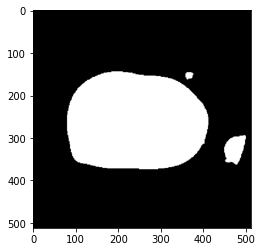

In [95]:
slice_num = 400

mask = np.load(f"data/dataset004/segmentations/10000/{slice_num}.npz")["arr_0"]
plt.imshow(mask[..., 4], cmap="gray")
plt.show()

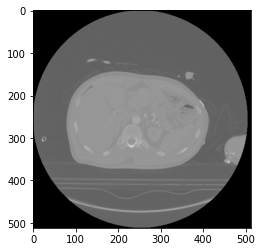

In [96]:
sid = 10000
pid = df_train_serirs_meta[df_train_serirs_meta["series_id"] == sid]["patient_id"].values[0]
ct = np.load(f"data/dataset001/train_images/{pid}/{sid}/{slice_num}.npy")
plt.imshow(ct, cmap="gray")
plt.show()